# Comparative Analysis of Optimizers in LSTM-Based Stock Price Prediction

This notebook investigates how different optimization algorithms affect the training dynamics and predictive performance of an LSTM network for single-step-ahead stock price forecasting. Using daily closing prices of Apple Inc. (AAPL) from Yahoo Finance, we compare a first-order optimizer (Adam) with two second-order methods (AdaHessian and SophiaG). For each optimizer, we train the same LSTM architecture, track training and validation loss, evaluate prediction accuracy on a held-out test set, and visualize predictions and directional accuracy. The results highlight that SophiaG can significantly improve error metrics at a computational cost comparable to Adam, whereas AdaHessian under the current hyperparameters fails to converge reliably.


In [1]:
!pip install torch_optimizer

## 1. Setup and Configuration

In this section we import the required libraries (PyTorch, NumPy, pandas, matplotlib, etc.), define the experiment configuration (ticker symbol, date range, sequence length, batch size, learning rate, and number of epochs), and set random seeds for reproducibility.


In [27]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import torch_optimizer as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch.optim.optimizer import Optimizer
from torch import Tensor
from typing import List, Optional
import math,time

This SophiaG(Optimizer) is from https://github.com/Liuhong99/Sophia/blob/main/sophia.py





In [28]:



class SophiaG(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.965, 0.99), rho = 0.04,
         weight_decay=1e-1, *, maximize: bool = False,
         capturable: bool = False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= rho:
            raise ValueError("Invalid rho parameter at index 1: {}".format(rho))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, rho=rho,
                        weight_decay=weight_decay,
                        maximize=maximize, capturable=capturable)
        super(SophiaG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('maximize', False)
            group.setdefault('capturable', False)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))

    @torch.no_grad()
    def update_hessian(self):
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                state['hessian'].mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)


    @torch.no_grad()
    def step(self, closure=None, bs=5120):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            state_steps = []
            hessian = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)

                if p.grad.is_sparse:
                    raise RuntimeError('Hero does not support sparse gradients')
                grads.append(p.grad)
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avgs.append(state['exp_avg'])
                state_steps.append(state['step'])
                hessian.append(state['hessian'])

                if self.defaults['capturable']:
                    bs = torch.ones((1,), dtype=torch.float, device=p.device) * bs

            sophiag(params_with_grad,
                  grads,
                  exp_avgs,
                  hessian,
                  state_steps,
                  bs=bs,
                  beta1=beta1,
                  beta2=beta2,
                  rho=group['rho'],
                  lr=group['lr'],
                  weight_decay=group['weight_decay'],
                  maximize=group['maximize'],
                  capturable=group['capturable'])

        return loss

def sophiag(params: List[Tensor],
          grads: List[Tensor],
          exp_avgs: List[Tensor],
          hessian: List[Tensor],
          state_steps: List[Tensor],
          capturable: bool = False,
          *,
          bs: int,
          beta1: float,
          beta2: float,
          rho: float,
          lr: float,
          weight_decay: float,
          maximize: bool):

    if not all(isinstance(t, torch.Tensor) for t in state_steps):
        raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")


    func = _single_tensor_sophiag

    func(params,
         grads,
         exp_avgs,
         hessian,
         state_steps,
         bs=bs,
         beta1=beta1,
         beta2=beta2,
         rho=rho,
         lr=lr,
         weight_decay=weight_decay,
         maximize=maximize,
         capturable=capturable)

def _single_tensor_sophiag(params: List[Tensor],
                         grads: List[Tensor],
                         exp_avgs: List[Tensor],
                         hessian: List[Tensor],
                         state_steps: List[Tensor],
                         *,
                         bs: int,
                         beta1: float,
                         beta2: float,
                         rho: float,
                         lr: float,
                         weight_decay: float,
                         maximize: bool,
                         capturable: bool):

    for i, param in enumerate(params):
        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        hess = hessian[i]
        step_t = state_steps[i]

        if capturable:
            assert param.is_cuda and step_t.is_cuda and bs.is_cuda

        if torch.is_complex(param):
            grad = torch.view_as_real(grad)
            exp_avg = torch.view_as_real(exp_avg)
            hess = torch.view_as_real(hess)
            param = torch.view_as_real(param)

        # update step
        step_t += 1

        # Perform stepweight decay
        param.mul_(1 - lr * weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

        if capturable:
            step_size = lr
            step_size_neg = step_size.neg()

            ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
            param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)
        else:
            step_size_neg = - lr

            ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
            param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)

## 1. Setup and Configuration

In this section we define the experiment configuration (ticker symbol, date range, sequence length, batch size, learning rate, and number of epochs), and set random seeds for reproducibility.


In [29]:

#  Configuration

ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2025-01-01"

seq_length = 60          # window length (common in many LSTM stock papers)
batch_size = 64
epochs = 30
lr = 1e-4
hidden_size = 64
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizers to compare
optimizers = ["adam", "sophiaG", "adahessian"]

torch.manual_seed(42)
np.random.seed(42)


## 2. Data Loading and Preprocessing

We download daily adjusted closing prices for AAPL from Yahoo Finance, normalize the series using min–max scaling, and construct sliding windows of length `seq_length` to form input–target pairs for single-step-ahead prediction. The data are then split into training, validation, and test sets and wrapped into PyTorch `DataLoader` objects.


In [30]:
# Download adjusted prices from Yahoo Finance
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
close = df["Close"].values.astype(np.float32)

# Reshape to column vector for scaler
series = close.reshape(-1, 1)

# Min–max scaling to [0, 1] (common in LSTM stock prediction)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(series)
np.shape(scaled_data)


[*********************100%***********************]  1 of 1 completed


(2516, 1)

In [31]:

# Build input sequences

def create_sequences(dataset, seq_length: int):
    """
    Convert a 1D time series into overlapping sequences of length `seq_length`
    with one-step-ahead targets.

    dataset: np.array of shape (N, 1)
    returns:
        X: (N - seq_length, seq_length, 1)
        y: (N - seq_length, 1)
    """
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length])
        y.append(dataset[i+seq_length])
    return np.array(X), np.array(y)

X, Y = create_sequences(scaled_data, seq_length=seq_length)

# Train/test split (80/20)
train_size = int(len(X) * 0.8)
X_train_full, Y_train_full = X[:train_size], Y[:train_size]
X_test,        Y_test      = X[train_size:], Y[train_size:]

val_size = int(len(X_train_full) * 0.2)
X_val, Y_val = X_train_full[-val_size:], Y_train_full[-val_size:]
X_train, Y_train = X_train_full[:-val_size], Y_train_full[:-val_size]

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
Y_val   = torch.tensor(Y_val,   dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
Y_test  = torch.tensor(Y_test,  dtype=torch.float32)


train_dataset = TensorDataset(X_train, Y_train)
val_dataset   = TensorDataset(X_val,   Y_val)
test_dataset  = TensorDataset(X_test,  Y_test)
# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, drop_last=False)


## 3. LSTM Model Architecture

We define a univariate LSTM model in PyTorch with one recurrent layer and a fully connected output layer. The network takes a sequence of past normalized prices as input and outputs the next-step predicted price.


In [32]:

# LSTM model

class LSTMModel(nn.Module):
    """
    Simple univariate LSTM for one-step-ahead prediction.

    input:  (batch, seq_len, 1)
    output: (batch, 1)
    """
    def __init__(self, input_size: int, hidden_size: int,
                 num_layers: int, output_size: int):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (B, T, input_size)
        out, _ = self.lstm(x)
        # Take last time step output: (B, hidden_size)
        out = out[:, -1, :]
        out = self.fc(out)      # (B, output_size)
        return out


## 4. Evaluation Metrics

To evaluate prediction quality, we implement functions to compute RMSE, MAE, MAPE, the coefficient of determination $R^2$, and directional accuracy (percentage of times the model correctly predicts the sign of the price change). These metrics are computed on the scaled test data.


In [33]:

# 4. Metrics (on scaled data)

def evaluate_metrics(y_true, y_pred):
    """
    Compute regression and directional metrics on numpy arrays.

    y_true, y_pred: shape (N,)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae  = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    # Directional accuracy

    if len(y_true) > 1:
      actual_dir = np.sign(y_true[1:] - y_true[:-1])
      pred_dir = np.sign(y_pred[1:] - y_pred[:-1])
      da = np.mean((actual_dir == pred_dir).astype(float)) * 100
    else:
        da = 0.0
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2, "DA": da}


## 5. Optimizers and Training Procedure

This section defines the three optimizers compared in the experiment

- **Adam**: standard first-order adaptive optimizer.
- **SophiaG**: scalable second-order optimizer with diagonal Hessian approximation and per-coordinate clipping.
- **AdaHessian**: second-order optimizer that uses a Hutchinson-based estimate of the Hessian diagonal.

We implement a training function that, for a given optimizer, trains the LSTM on the training set, monitors validation loss, applies early stopping, and records the time required to train.


In [34]:

def get_optimizer(optimizer_name, model_params, lr):
    """
    Return an initialized optimizer given its name.
    """
    if optimizer_name == "adam":
        return torch.optim.Adam(
            model_params, lr=lr,
            betas=(0.9, 0.999), eps=1e-4, weight_decay=0.0
        )
    elif optimizer_name == "sophiaG":
        return SophiaG(
            model_params, lr=lr,
            betas=(0.9, 0.999),
            rho=0.04,
            weight_decay=0.0
        )
    elif optimizer_name == "adahessian":
        return optim.Adahessian(
            model_params, lr=lr,
            betas=(0.9, 0.999),
            eps=1e-4, weight_decay=0.0,
            hessian_power=0.5
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

Using Optimizer defaults hyperparameters





In [9]:

def get_optimizer(optimizer_name, model_params, lr):
    """
    Return an initialized optimizer given its name.
    """
    if optimizer_name == "adam":
        return torch.optim.Adam(
            model_params, lr=0.001,
            betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0
        )
    elif optimizer_name == "sophiaG":
        return SophiaG(
            model_params, lr=lr,
            betas=(0.965, 0.99),
            rho=0.04,
            weight_decay=0.1
        )
    elif optimizer_name == "adahessian":
        return optim.Adahessian(
            model_params, lr=0.15,
            betas=(0.9, 0.999),
            eps=1e-4, weight_decay=0.0,
            hessian_power=0.5
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")




In [35]:
class EarlyStopping:
    """
    Early stop training if validation loss does not improve after
    `patience` epochs by at least `min_delta`.
    """
    def __init__(self, patience=5, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model):

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0

            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [36]:
def train_and_evaluate(optimizer_name, model,
                       train_loader, val_loader, test_loader,
                       epochs=epochs, lr=lr):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)

    early_stopper = EarlyStopping(patience=7, min_delta=1e-5)

    train_losses = []
    val_losses = []
    start_time = time.time()

    for epoch in range(epochs):
        #  train
        model.train()
        epoch_train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
             # create_graph needed only for AdaHessian
            loss.backward(create_graph=(optimizer_name == "adahessian"))
            optimizer.step()

            epoch_train_loss += loss.item() * batch_x.size(0)
        epoch_train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                epoch_val_loss += val_loss.item() * batch_x.size(0)
        epoch_val_loss /= len(val_loader.dataset)

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        print(f"{optimizer_name.upper()} Epoch {epoch+1}/{epochs} "
              f"- Train: {epoch_train_loss:.6f}  Val: {epoch_val_loss:.6f}")

        # early stopping check
        early_stopper.step(epoch_val_loss, model)
        if early_stopper.should_stop:
            print(f"Early stopping triggered for {optimizer_name.upper()} at epoch {epoch+1}")
            break

    total_time = time.time() - start_time

    # Load best model weights (lowest validation loss)
    if early_stopper.best_state is not None:
        model.load_state_dict(early_stopper.best_state)

    #test evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            y_true.extend(batch_y.squeeze(1).cpu().numpy())
            y_pred.extend(outputs.squeeze(1).cpu().numpy())

    metrics = evaluate_metrics(y_true, y_pred)
    print(f"\nFinal {optimizer_name.upper()} metrics (best val model): {metrics}")
    print(f"Total training time ({optimizer_name.upper()}): {total_time:.2f} seconds")

    return train_losses, val_losses, metrics, y_true, y_pred, total_time


## 6. Running Experiments for Each Optimizer

Here we loop over the three optimizers (Adam, SophiaG, AdaHessian), reinitialize the LSTM for each run, and call the training/evaluation routine. For each optimizer we store the per-epoch training and validation losses, test-set metrics, predictions, and total training time in a `results` dictionary.


In [37]:

#  Run experiments

torch.manual_seed(42)
np.random.seed(42)
results = {}
for opt in optimizers:
    print(f"\n=== Training with {opt.upper()} ===")
    model = LSTMModel(input_size=1,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      output_size=1)
    tr_losses, val_losses, metrics, y_true, y_pred, t_time = train_and_evaluate(
        opt, model, train_loader, val_loader, test_loader
    )
    results[opt] = {
        "train_losses": tr_losses,
        "val_losses": val_losses,
        "metrics": metrics,
        "y_true": y_true,
        "y_pred": y_pred,
        "time": t_time
    }




=== Training with ADAM ===
ADAM Epoch 1/30 - Train: 0.020695  Val: 0.198824
ADAM Epoch 2/30 - Train: 0.018299  Val: 0.178198
ADAM Epoch 3/30 - Train: 0.017256  Val: 0.164969
ADAM Epoch 4/30 - Train: 0.016688  Val: 0.157634
ADAM Epoch 5/30 - Train: 0.016230  Val: 0.150815
ADAM Epoch 6/30 - Train: 0.015744  Val: 0.146704
ADAM Epoch 7/30 - Train: 0.015243  Val: 0.142325
ADAM Epoch 8/30 - Train: 0.014699  Val: 0.135055
ADAM Epoch 9/30 - Train: 0.014099  Val: 0.129355
ADAM Epoch 10/30 - Train: 0.013453  Val: 0.123549
ADAM Epoch 11/30 - Train: 0.012708  Val: 0.113973
ADAM Epoch 12/30 - Train: 0.011878  Val: 0.106045
ADAM Epoch 13/30 - Train: 0.010892  Val: 0.096381
ADAM Epoch 14/30 - Train: 0.009735  Val: 0.084387
ADAM Epoch 15/30 - Train: 0.008342  Val: 0.069852
ADAM Epoch 16/30 - Train: 0.006607  Val: 0.050868
ADAM Epoch 17/30 - Train: 0.004410  Val: 0.027886
ADAM Epoch 18/30 - Train: 0.001991  Val: 0.007342
ADAM Epoch 19/30 - Train: 0.000345  Val: 0.000691
ADAM Epoch 20/30 - Train: 0.000

## 7. Convergence Analysis

We visualize training and validation MSE as a function of epochs for all three optimizers. These plots allow us to compare convergence speed, stability, and overfitting behavior across optimizers.


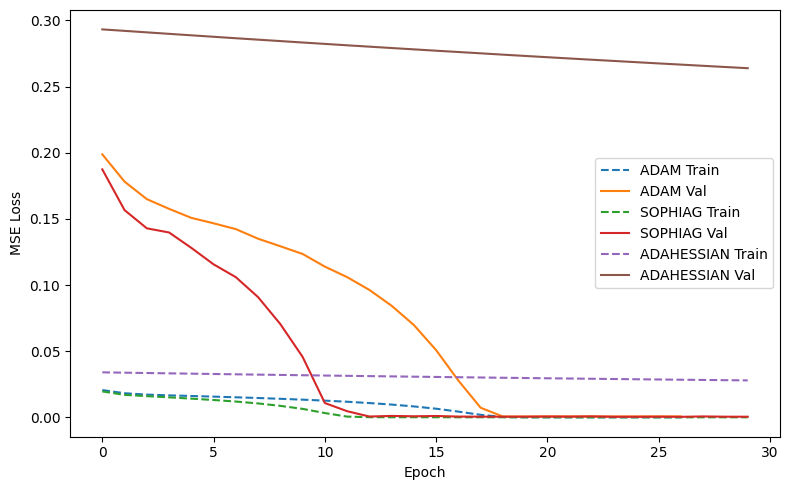

In [38]:

plt.figure(figsize=(8, 5))
for opt in optimizers:
    plt.plot(results[opt]["train_losses"], label=f"{opt.upper()} Train", linestyle="--")
    plt.plot(results[opt]["val_losses"],   label=f"{opt.upper()} Val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()



## 8. Prediction Quality and Directional Accuracy

For each optimizer, we plot predicted vs. actual normalized prices on the test set, as well as directional-accuracy plots that mark correctly and incorrectly predicted up/down movements. This provides a qualitative view of how well the LSTM captures both trend and local fluctuations under each optimization scheme.


In [39]:

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Actual", color="black")
    plt.plot(y_pred, label="Predicted", color="red", alpha=0.7)

    plt.title(title)


    plt.xlabel("Time")
    plt.ylabel("Scaled Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_directional_accuracy_markers(y_true, y_pred, title="Directional Accuracy"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    actual_dir = np.sign(y_true[1:] - y_true[:-1])
    pred_dir   = np.sign(y_pred[1:] - y_true[:-1])

    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label="Actual Price", color="black")
    plt.plot(y_pred, label="Predicted Price", color="magenta", alpha=0.7)

    plotted_labels = set()
    for i in range(len(actual_dir)):
        # Actual
        actual_label = "Actual Up" if actual_dir[i] > 0 else "Actual Down"
        label_actual = actual_label if actual_label not in plotted_labels else ""
        plt.scatter(i+1, y_true[i+1],
                    color="green" if actual_dir[i] > 0 else "blue",
                    marker="^" if actual_dir[i] > 0 else "v",
                    alpha=0.6, label=label_actual)
        plotted_labels.add(actual_label)

        # Predicted
        pred_label = "Pred Up" if pred_dir[i] > 0 else "Pred Down"
        label_pred = pred_label if pred_label not in plotted_labels else ""
        plt.scatter(i+1 + 0.1, y_pred[i+1],
                    color="orange" if pred_dir[i] > 0 else "purple",
                    marker="^" if pred_dir[i] > 0 else "v",
                    alpha=0.6, label=label_pred)
        plotted_labels.add(pred_label)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Scaled Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




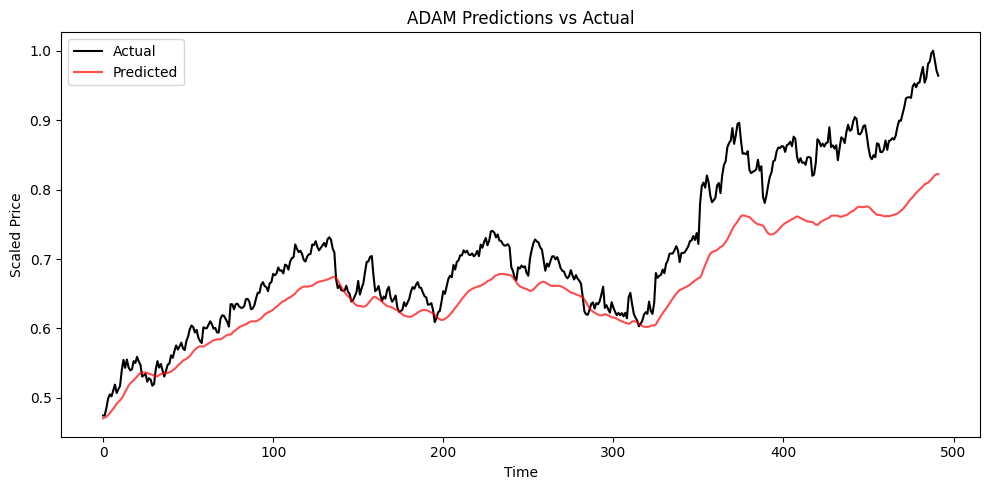

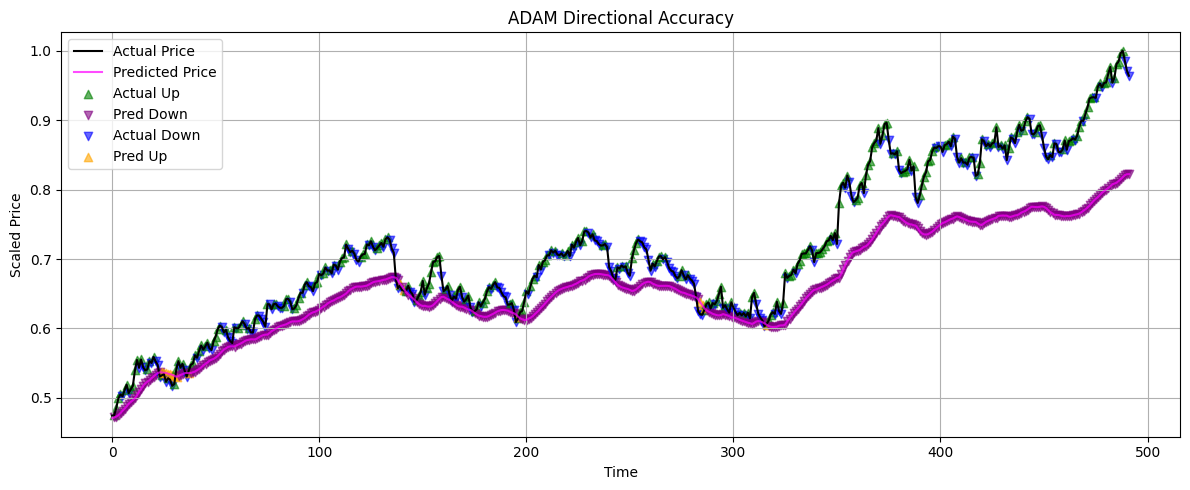

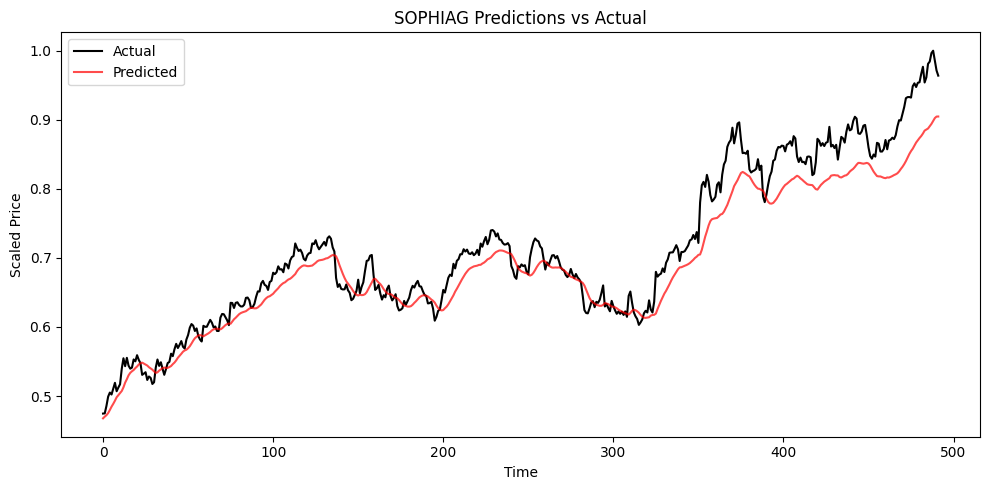

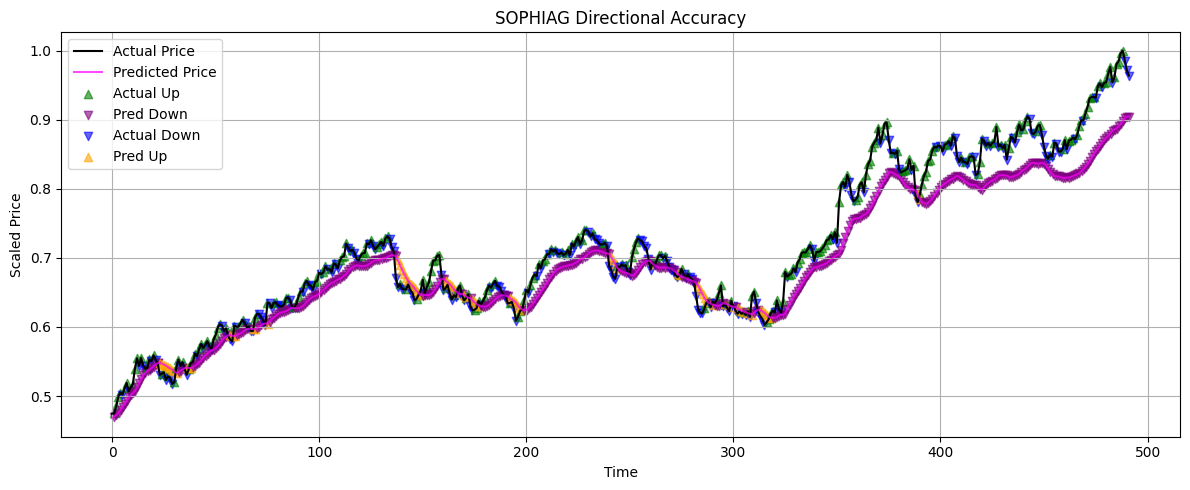

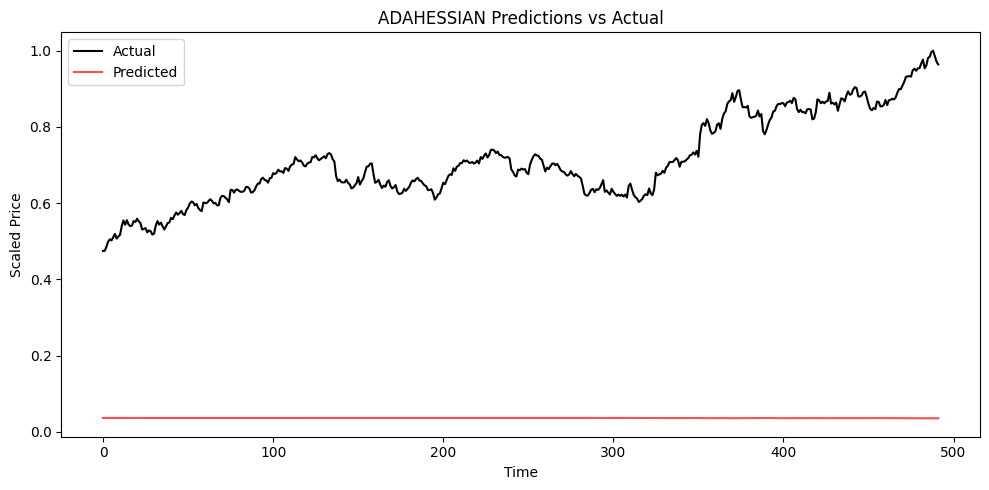

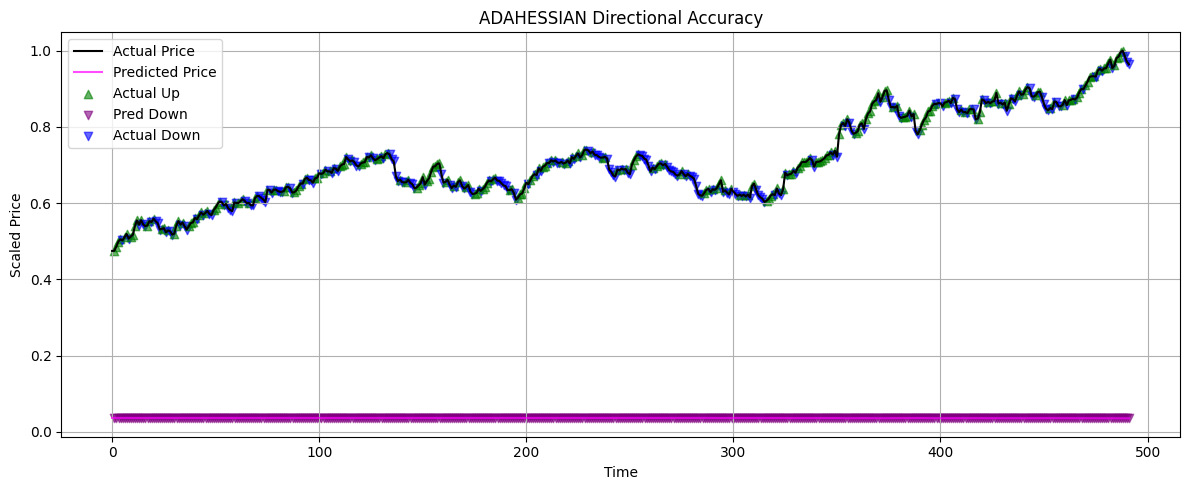

In [40]:
# Prediction and directional-accuracy plots per optimizer
for opt in optimizers:
    y_true = results[opt]["y_true"]
    y_pred = results[opt]["y_pred"]
    plot_predictions(y_true, y_pred, f"{opt.upper()} Predictions vs Actual")
    plot_directional_accuracy_markers(y_true, y_pred,
                                      f"{opt.upper()} Directional Accuracy")

## 9. Summary of Quantitative Results

Finally, we aggregate the test-set metrics and training times into a summary table for easier comparison. This table underpins the discussion and conclusions reported in the accompanying write-up.


In [41]:

# Summary table
summary_rows = []
for opt in optimizers:
    row = {"Optimizer": opt.upper(), "Time_s": results[opt]["time"]}
    row.update(results[opt]["metrics"])
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n=== Metrics and Time Summary ===")
print(summary_df)



=== Metrics and Time Summary ===
    Optimizer      Time_s      RMSE       MAE       MAPE         R2         DA
0        ADAM   20.121058  0.068525  0.054198   6.990178   0.638236  52.953157
1     SOPHIAG   22.075940  0.036272  0.028096   3.676491   0.898636  53.767821
2  ADAHESSIAN  131.710176  0.685335  0.675762  94.815498 -35.185780  48.268839


Using Optimizer defaults hyperparameters

In [16]:

#  Summary table
summary_rows = []
for opt in optimizers:
    row = {"Optimizer": opt.upper(), "Time_s": results[opt]["time"]}
    row.update(results[opt]["metrics"])
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n=== Metrics and Time Summary ===")
print(summary_df)



=== Metrics and Time Summary ===
    Optimizer     Time_s      RMSE       MAE      MAPE        R2         DA
0        ADAM   8.267064  0.043369  0.033849  4.419050  0.855091  53.156823
1     SOPHIAG  20.981972  0.046584  0.036592  4.742491  0.832814  53.156823
2  ADAHESSIAN  59.683593  0.028065  0.021889  2.900387  0.939317  52.138493
